# View Fors2 , View spectra one by one and Compare to SL and write in a pdf file

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/01/21
- last update : 2023/03/20
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

## Import

In [1]:
import os,sys,re
from astropy.io import fits
from astropy.table import Table

In [2]:
# Import some generally useful packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
from def_raw_seds import *

In [7]:
from raw_data_analysis import *

In [8]:
# Import the primary photometry classes from rubin_sim.photUtils

#import rubin_sim.phot_Utils.Bandpass as Bandpass
#import rubin_sim.phot_Utils.Sed as Sed
#from rubin_sim.data import get_data_dir

In [9]:
#pysynphot_root_path=os.environ['PYSYN_CDBS']
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
#import pysynphot as S
#S.refs.setref(area=1)
#S.refs.getref()

In [10]:
from astropy.io import fits

In [11]:
from scipy.ndimage import gaussian_filter1d

In [12]:
from GalaxyLineDict import build_emissionlinesdict

In [13]:
from matplotlib.backends.backend_pdf import PdfPages

In [14]:
import copy

In [15]:
def SaveImageInPdf(all_figs,outputfile):
    """
    """
    with PdfPages(outputfile) as pdf:
        for fig in all_figs:
            pdf.savefig(fig)
            plt.close()

# Start

In [16]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /home/joseph/PhotoZ_PhD/StudyFors2SED


## Configuration

### Emission lines

In [17]:
#df_lines=pd.read_excel("datatools/GalEmissionLines.xlsx")

In [18]:
#df_lines

In [19]:
#df_sdss_lines = pd.read_excel("datatools/sdss_galaxylines.xlsx")

In [20]:
#df_sdss_lines

# Lines

In [21]:
lines_to_plot=build_emissionlinesdict()

In [22]:
lines_to_plot

{'K': {'wls': array([3934.777]), 'name': 'K', 'type': 'absorption'},
 'H': {'wls': array([4341.68 , 4862.68 , 6564.61 , 3969.588]),
  'name': 'H',
  'type': 'absorption'},
 'G': {'wls': array([4305.61]), 'name': 'G', 'type': 'absorption'},
 'Mg': {'wls': array([5176.7]), 'name': 'Mg', 'type': 'absorption'},
 'Na': {'wls': array([5895.6]), 'name': 'Na', 'type': 'absorption'},
 'H8': {'wls': array([3889.064]), 'name': '$H8$', 'type': 'emission'},
 'H9': {'wls': array([3835.391]), 'name': '$H9$', 'type': 'emission'},
 'H10': {'wls': array([3797.904]), 'name': '$H10$', 'type': 'emission'},
 'H11': {'wls': array([3770.637]), 'name': '$H11$', 'type': 'emission'},
 'H{alpha}': {'wls': array([6562.819]),
  'name': '$H_\\alpha$',
  'type': 'emission'},
 'H{beta}': {'wls': array([4861.333]),
  'name': '$H_\\beta$',
  'type': 'emission'},
 'H{gamma}': {'wls': array([4340.471]),
  'name': '$H_\\gamma$',
  'type': 'emission'},
 'H{delta}': {'wls': array([4101.742]),
  'name': '$H_\\delta$',
  'type

In [23]:
def plot_line(ax,line_name):
    
    #keys = lines_to_plot.keys()
    #for the_key in keys:
    #    if the_key in line_name:
    #        print("the_key=",the_key," line_name=",line_name)
    #        line_name=the_key
    #        break
            
    posx0=0.0
    posy0=0.05
    fontsize=12
    the_color = {"emission":'r',"absorption":"g","break":"purple"}
    the_line_to_plot = lines_to_plot[line_name]
    wls = the_line_to_plot["wls"]
    tag = the_line_to_plot["name"]
    typ = the_line_to_plot["type"]
    
    xlim = ax.get_xlim()
    for wl in wls:
        ax.axvline(wl, lw=2, color=the_color[typ])
        xpos = (wl - xlim[0]) / (xlim[1] - xlim[0])+posx0 
        if 0 < xpos < 1:
            ax.annotate(tag, xy=(xpos, posy0), rotation=0, ha='left', va='bottom',
                            xycoords='axes fraction', color=the_color[typ], fontsize=fontsize)
    return ax

## StarLight

In [24]:
filename = 'datatools/spectra_SL_data.fits'
hdu = fits.open(filename)
data_in=hdu[0].data
hdr_in = hdu[0].header

In [25]:
NSED_SL = data_in.shape[0]-3
NWL_SL = data_in.shape[1]-1

In [26]:
wavelengths_SL = data_in[0,1:] 
flambdas_average_SL = data_in[1,1:] 
flambdas_std_SL = data_in[2,1:] 
spec_SL = data_in[3:,1:] 
all_numbers_SL = data_in[3:,0] 

### Fors2

## Start

### Catalog

In [27]:
t = Table.read(filename_fits_catalog)

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/astropy/io/fits/connect.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


In [28]:
t

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
1,,13.52815,-28.40486,0.55409,,20.79,166227,55,10.0,1,"[OII],H8,K,H"
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"
4,,13.52216,-28.40914,0.68653,,21.62,205959,123,10.6,1,"[OII],H9,K,H,G,H{beta}"
7,,13.50974,-28.42972,0.32371,,22.34,97111,11,16.7,6,"[OII],H{beta},[OIII],H{alpha}"
9,,13.50219,-28.40641,0.29266,,21.6,87798,58,13.1,1,"H9,H8,K,H"
11,,13.49724,-28.39487,0.62688,,22.09,188063,17,24.3,3,"[OII],H10,H8,K,H,H{delta}"
12,,13.49584,-28.39125,0.2973,,21.97,89189,30,14.8,2,"[OII],H10,H9,H8,K,H"


### List

In [29]:
lst=fors2_jct_SL() #remet les spectres dans le rest frame (ie a z=0)

In [30]:
lst = sorted(lst)
print(lst)

['SPEC102', 'SPEC106', 'SPEC107', 'SPEC109', 'SPEC110', 'SPEC111', 'SPEC112', 'SPEC113', 'SPEC114', 'SPEC115', 'SPEC117', 'SPEC118', 'SPEC120', 'SPEC121', 'SPEC123', 'SPEC127', 'SPEC128', 'SPEC13', 'SPEC132', 'SPEC134', 'SPEC135', 'SPEC137', 'SPEC138', 'SPEC141', 'SPEC149', 'SPEC151', 'SPEC152', 'SPEC156', 'SPEC160', 'SPEC161', 'SPEC164', 'SPEC171', 'SPEC178', 'SPEC179', 'SPEC181', 'SPEC182', 'SPEC183', 'SPEC184', 'SPEC185', 'SPEC186', 'SPEC187', 'SPEC188', 'SPEC189', 'SPEC19', 'SPEC191', 'SPEC192', 'SPEC193', 'SPEC194', 'SPEC196', 'SPEC197', 'SPEC198', 'SPEC2', 'SPEC204', 'SPEC205', 'SPEC210', 'SPEC214', 'SPEC218', 'SPEC221', 'SPEC222', 'SPEC223', 'SPEC226', 'SPEC227', 'SPEC231', 'SPEC233', 'SPEC234', 'SPEC235', 'SPEC236', 'SPEC237', 'SPEC238', 'SPEC24', 'SPEC240', 'SPEC242', 'SPEC243', 'SPEC244', 'SPEC245', 'SPEC246', 'SPEC248', 'SPEC249', 'SPEC25', 'SPEC250', 'SPEC252', 'SPEC253', 'SPEC258', 'SPEC259', 'SPEC260', 'SPEC261', 'SPEC262', 'SPEC264', 'SPEC265', 'SPEC266', 'SPEC267', 'SPE

In [31]:
all_specfilenames = os.listdir(path_out_jct)

In [32]:
all_specfilenames = sorted(all_specfilenames)

In [33]:
all_numbers = [ int(re.findall('^SPEC(.*)[.]txt$',fn)[0]) for fn in all_specfilenames ]

In [34]:
all_numbers = sorted(all_numbers)

In [35]:
print(all_numbers)

[2, 3, 9, 13, 19, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 45, 47, 49, 51, 55, 57, 58, 59, 61, 62, 66, 67, 68, 69, 70, 71, 72, 73, 77, 79, 80, 83, 84, 85, 86, 87, 89, 91, 93, 96, 97, 102, 106, 107, 109, 110, 111, 112, 113, 114, 115, 117, 118, 120, 121, 123, 127, 128, 132, 134, 135, 137, 138, 141, 149, 151, 152, 156, 160, 161, 164, 171, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 198, 204, 205, 210, 214, 218, 221, 222, 223, 226, 227, 231, 233, 234, 235, 236, 237, 238, 240, 242, 243, 244, 245, 246, 248, 249, 250, 252, 253, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268, 271, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 287, 288, 291, 292, 294, 295, 296, 297, 298, 301, 302, 303, 304, 305, 306, 307, 308, 309, 313, 315, 317, 318, 319, 321, 322, 323, 324, 325, 326, 327, 328, 329, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 343, 344, 345, 346, 348, 349, 350, 351, 352, 353, 354, 355, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367

In [36]:
NSED = len(all_numbers)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [37]:
cut = t["ID"] == 3
t[cut]

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"


In [38]:
all_spectra = []
all_wl = []
all_tag = []
all_lines = []
#all_sed = []
all_redshifts = []
all_num = []
all_ra = []
all_dec = []

for idx,the_num in enumerate(all_numbers):
    tcut = t["ID"] == the_num
    redshift = t[tcut]["z"].value[0]
    lines = t[tcut]["Lines"].value[0]
    ra = t[tcut]["RAJ2000"].value[0]
    dec = t[tcut]["DEJ2000"].value[0]
    filename = f"SPEC{the_num}.txt"
    tag = f"SPEC{the_num} , z={redshift:.2f}, lines={lines.decode().split(' ')[0]}"
    fullfilename = os.path.join(path_out_jct,filename)

    arr = np.loadtxt(fullfilename)
    all_wl.append(arr[:,0])
    all_spectra.append(arr[:,1])
    all_tag.append(tag)
    all_lines.append(lines) 
    all_redshifts.append(redshift)
    all_num.append(the_num) 
    all_ra.append(ra) 
    all_dec.append(dec)

all_wl = np.array(all_wl)
all_spectra = np.array(all_spectra)
all_tag = np.array(all_tag)
all_lines = np.array(all_lines)
all_redshifts = np.array(all_redshifts)
all_num = np.array(all_num)
all_ra = np.array(all_ra)
all_dec = np.array(all_dec)

/tmp/ipykernel_1651/2295684591.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_wl = np.array(all_wl)
/tmp/ipykernel_1651/2295684591.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_spectra = np.array(all_spectra)


In [39]:
if 0:
    for idx in range(NSED):
        plt.figure(figsize=(16,2))
        plt.plot(all_wl[idx],all_spectra[idx], color=all_colors[idx],label=all_tag[idx])
        plt.legend(loc="upper right")
        plt.grid()
        plt.axvline(4150,color="k")
        plt.axvline(4250,color="k")
#    plt.ylim(-0.02,0.4)
        plt.xlim(2000.,8000.)
        plt.show()


the_lines =  b'K,H,H{delta},G                                                              \r'
K
H
H{delta}
G


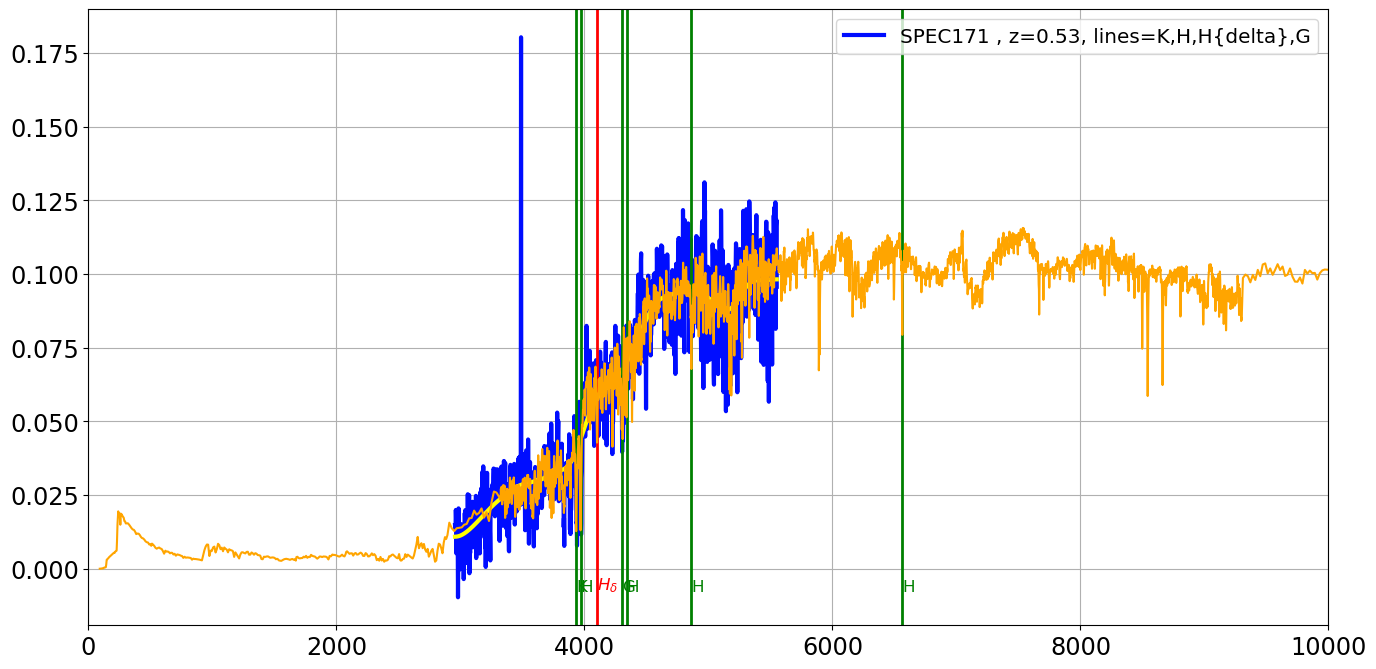

In [58]:
idx=np.where(np.asarray(all_numbers) == 171)[0][0]
the_lines = all_lines[idx]
print("the_lines = ",the_lines)

all_elements  = the_lines.decode().split(",")


fig, axs = plt.subplots(1, 1, figsize=(16, 8))
ax=axs
the_wl_fors2 = all_wl[idx]
the_flux_fors2 = all_spectra[idx]
the_max_flux_1 = the_wl_fors2.max()
ax.plot(the_wl_fors2 ,the_flux_fors2 ,'-' ,color=all_colors[idx],label=all_tag[idx],lw=3)

the_flux_fors2_filt  = gaussian_filter1d(the_flux_fors2,40)
ax.plot(the_wl_fors2 ,the_flux_fors2_filt ,'-' ,color='yellow',lw=3)

wlmin = the_wl_fors2.min()
wlmax = the_wl_fors2.max()

I1=np.trapz(the_flux_fors2_filt ,the_wl_fors2)

ax.legend(loc="upper right")
ax.grid()

wl1=4150
wl2=4250

#ax.axvline(wl1,color="grey")
#ax.axvline(wl2,color="grey")




#    plt.ylim(-0.02,0.4)
ax.set_xlim(0.,10000.)
for el in all_elements:
    el=el.split(" ")[0]  
    print(el)
    if len(el)>0:
        plot_line(ax,el)

        
the_num = all_numbers[idx]

idx_sl=np.where(all_numbers_SL==the_num)[0][0]
the_spectrum_SL = spec_SL[idx_sl]

the_max_flux_2 = the_spectrum_SL.max()

wavelengths_SL_indexes=np.where(np.logical_and(wavelengths_SL>=wlmin,wavelengths_SL<wlmax))[0]

the_spectrum_SL_flux_cut = the_spectrum_SL[wavelengths_SL_indexes]
the_spectrum_SL_wl_cut = wavelengths_SL[wavelengths_SL_indexes]

I2=np.trapz(the_spectrum_SL_flux_cut,the_spectrum_SL_wl_cut)

g=I1/I2

the_flux_SL_toplot= g*spec_SL[idx_sl]

the_max_flux_2=the_flux_SL_toplot.max()

ymax=1.1*max(the_max_flux_1,the_max_flux_2)

ax.plot(wavelengths_SL,the_flux_SL_toplot,color="orange")

ymin=0

#ax.set_ylim(ymin,ymax)

the_lines =  b'K,H,H{delta},G                                                              \r'
K
H
H{delta}
G
K
H
H{delta}
G


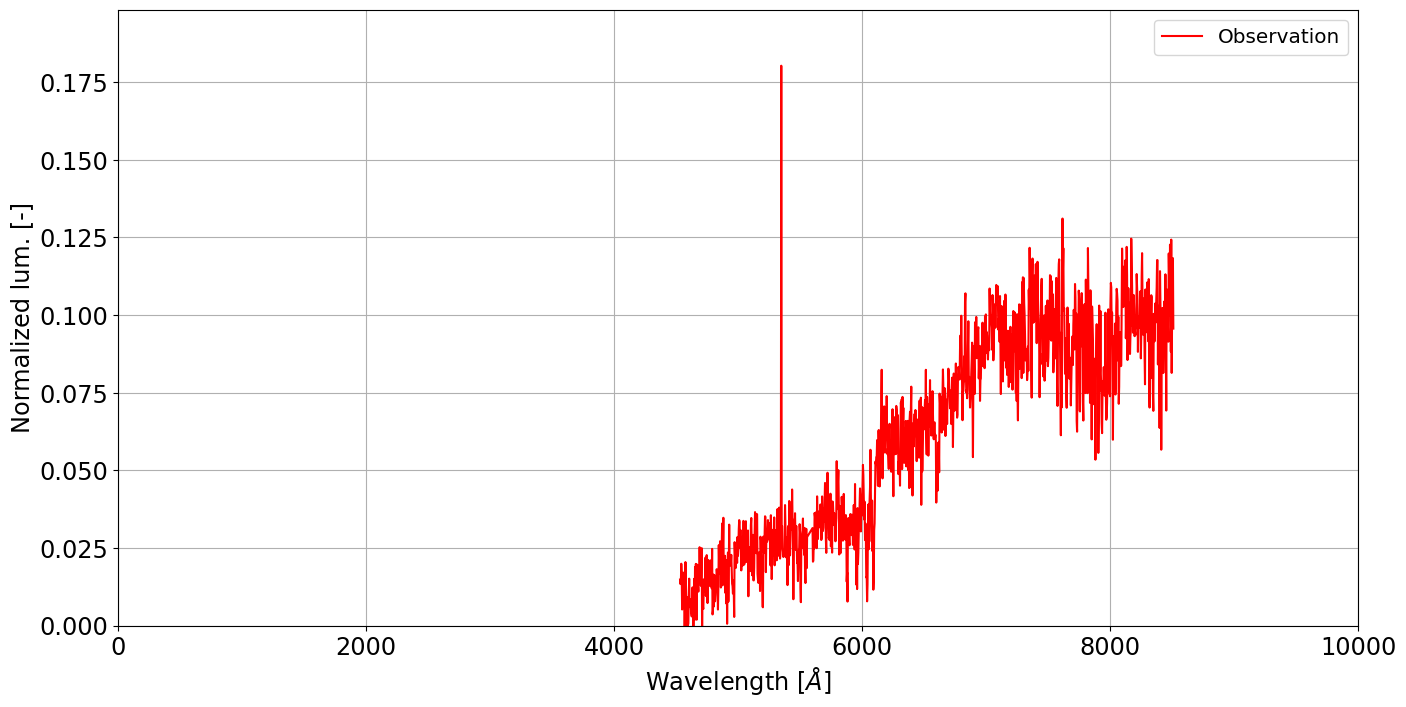

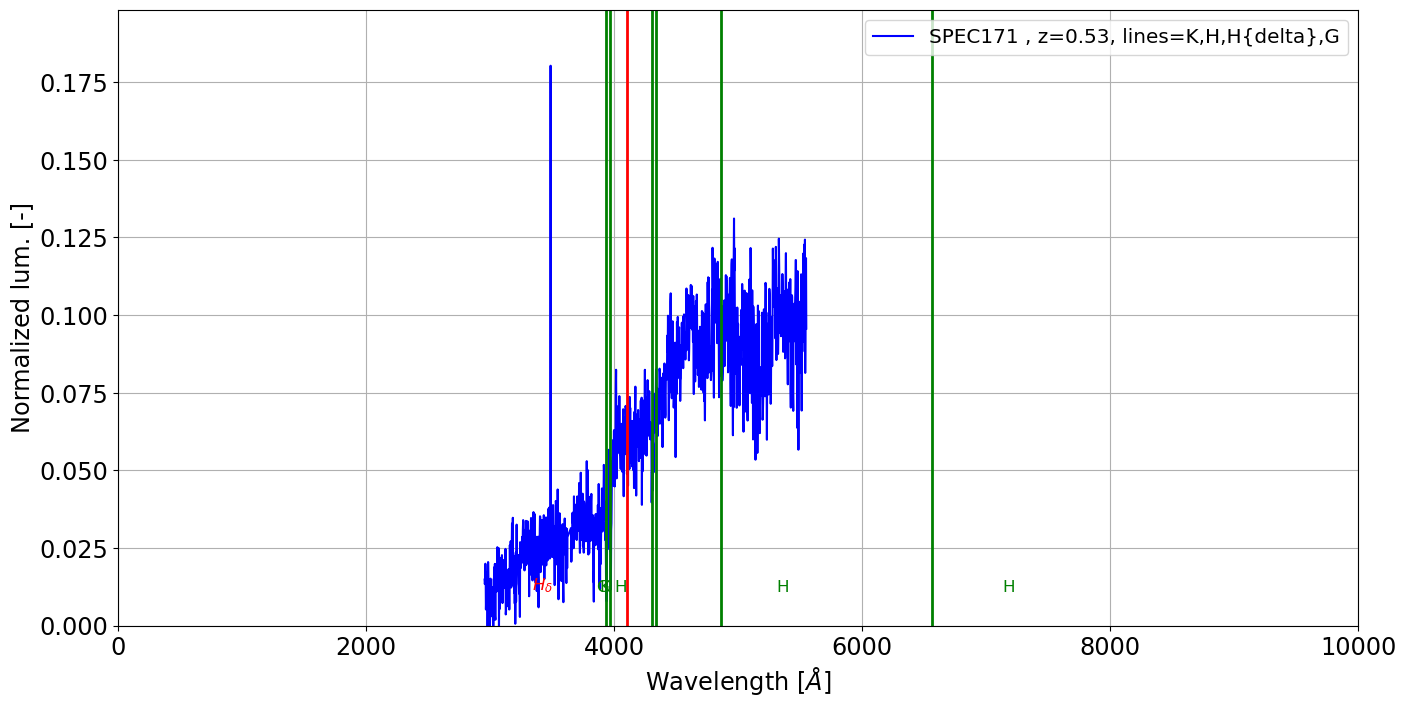

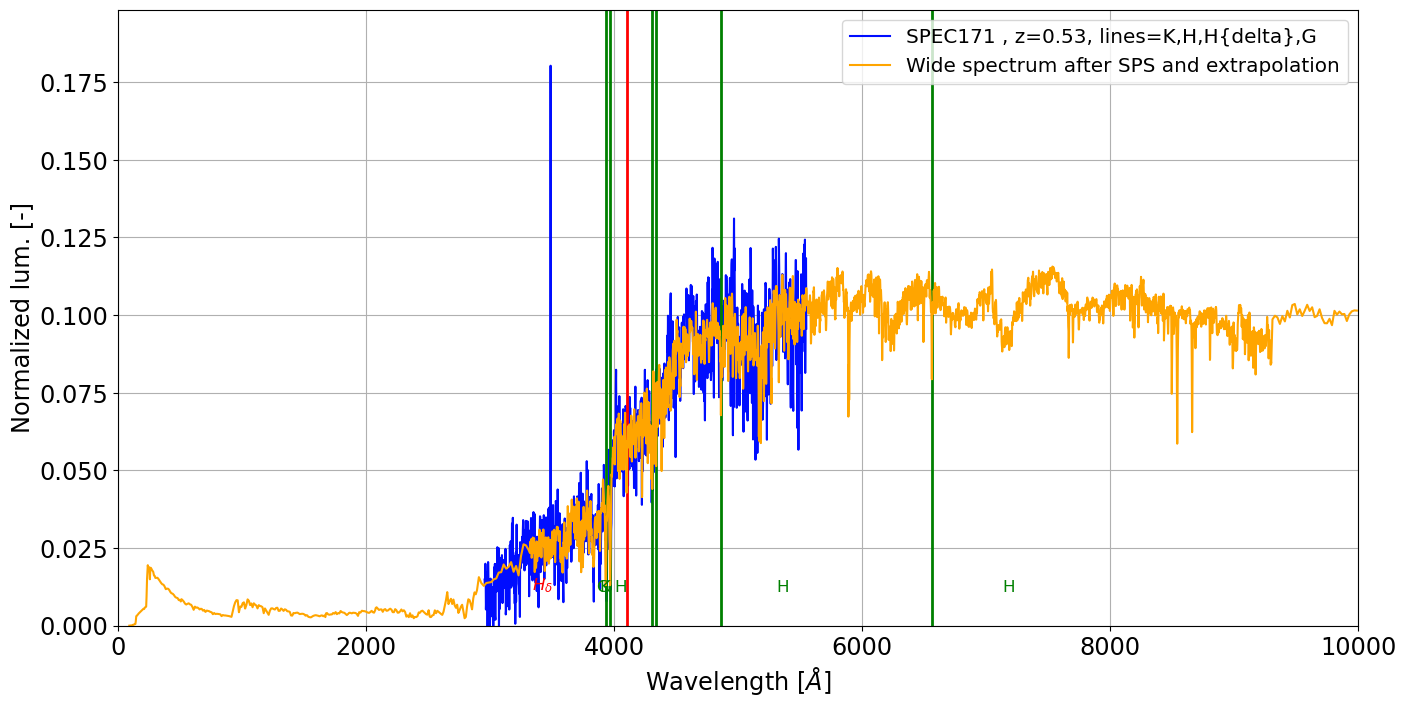

In [59]:
idx=np.where(np.asarray(all_numbers) == 171)[0][0]
the_lines = all_lines[idx]
print("the_lines = ",the_lines)
all_elements  = the_lines.decode().split(",")

the_wl_fors2 = all_wl[idx]
the_flux_fors2 = all_spectra[idx]
the_max_flux_1 = the_flux_fors2.max()

wlmin = the_wl_fors2.min()
wlmax = the_wl_fors2.max()

I1=np.trapz(the_flux_fors2_filt ,the_wl_fors2)

wl1=4150
wl2=4250

#ax.axvline(wl1,color="grey")
#ax.axvline(wl2,color="grey")
        
the_num = all_numbers[idx]
z=all_redshifts[idx]

idx_sl=np.where(all_numbers_SL==the_num)[0][0]
the_spectrum_SL = spec_SL[idx_sl]
the_max_flux_2 = the_spectrum_SL.max()
wavelengths_SL_indexes=np.where(np.logical_and(wavelengths_SL>=wlmin,wavelengths_SL<wlmax))[0]
the_spectrum_SL_flux_cut = the_spectrum_SL[wavelengths_SL_indexes]
the_spectrum_SL_wl_cut = wavelengths_SL[wavelengths_SL_indexes]

I2=np.trapz(the_spectrum_SL_flux_cut,the_spectrum_SL_wl_cut)

g=I1/I2
the_flux_SL_toplot= g*spec_SL[idx_sl]
the_max_flux_2=the_flux_SL_toplot.max()

ymax=1.1*max(the_max_flux_1,the_max_flux_2)
ymin=0

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(the_wl_fors2*(1+z), the_flux_fors2, '-', color='red', label="Observation")
ax.set_xlim(0.,10000.)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("Wavelength [$\AA$]")
ax.set_ylabel("Normalized lum. [-]")
ax.legend(loc="upper right")
ax.grid()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(the_wl_fors2 ,the_flux_fors2 ,'-' ,color='blue',label=all_tag[idx])
for el in all_elements:
    el=el.split(" ")[0]  
    print(el)
    if len(el)>0:
        plot_line(ax,el)
ax.set_xlim(0.,10000.)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("Wavelength [$\AA$]")
ax.set_ylabel("Normalized lum. [-]")
ax.legend(loc="upper right")
ax.grid()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(the_wl_fors2, the_flux_fors2, '-', color=all_colors[idx], label=all_tag[idx])
#ax.set_ylim(-0.02,0.4)
for el in all_elements:
    el=el.split(" ")[0]  
    print(el)
    if len(el)>0:
        plot_line(ax,el)
ax.plot(wavelengths_SL, the_flux_SL_toplot, color="orange", label="Wide spectrum after SPS and extrapolation")
ax.set_xlim(0.,10000.)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("Wavelength [$\AA$]")
ax.set_ylabel("Normalized lum. [-]")
ax.legend(loc="upper right")
ax.grid()

## Write in pdf File

In [42]:
NFIGSPERPAGE = 8
NCOLSPERPAGE = 1
NROWSPERPAGE = int(np.ceil(NFIGSPERPAGE/NCOLSPERPAGE)) 

In [43]:
if False:
    all_figs = []
    idx_page=0

    for idx in range(0,NSED):

        if idx%NFIGSPERPAGE == 0:
            idx_page+=1

            plt.tight_layout()
            plt.show()
            # save previous page
            if idx_page>1:
                all_figs.append(copy.deepcopy(fig))

            # create a new page
            fig=plt.figure(figsize=(16,30))
            idx_fig_inpage=0

        #increase fig counter in mage
        idx_fig_inpage+=1    

        ax=fig.add_subplot(NROWSPERPAGE,NCOLSPERPAGE,idx_fig_inpage)


        the_tag=all_tag[idx] 
        print(f"===================== SED {idx} : {the_tag}=======================")

        the_lines = all_lines[idx]
        print("the_lines = ",the_lines)
        all_elements  = the_lines.decode().split(",")


        the_wl_fors2 = all_wl[idx]
        the_flux_fors2 = all_spectra[idx]
        ymax1 = the_flux_fors2.max()


        #ax.plot(the_wl_fors2,the_flux_fors2,'-' ,color=all_colors[idx],label=all_tag[idx],lw=4)
        ax.plot(the_wl_fors2,the_flux_fors2,'-' ,color='b',label=all_tag[idx],lw=4)

        the_flux_fors2_filt  = gaussian_filter1d(the_flux_fors2,40)
        #ax.plot(the_wl_fors2 ,the_flux_fors2_filt ,'-' ,color='yellow',lw=3)

        wlmin = the_wl_fors2.min()
        wlmax = the_wl_fors2.max()

        I1=np.trapz(the_flux_fors2_filt,the_wl_fors2)


        ax.legend(loc="upper right")
        ax.grid()

        wl1=4150
        wl2=4250

    #    ax.axvline(wl1,color="grey")
    #    ax.axvline(wl2,color="grey")
    #    plt.ylim(-0.02,0.4)

        ax.set_xlim(0.,10000.)
        for el in all_elements:
            el=el.split(" ")[0]  
            el=el.split("\r")[0]  
            print(el)
            if len(el)>0:
                plot_line(ax,el)


        the_num = all_numbers[idx]
        print(f"the_num = {the_num}")

        idx_sl=np.where(all_numbers_SL==the_num)[0][0]
        the_spectrum_SL = spec_SL[idx_sl]

        wavelengths_SL_indexes=np.where(np.logical_and(wavelengths_SL>=wlmin,wavelengths_SL<wlmax))[0]

        the_spectrum_SL_flux_cut = the_spectrum_SL[wavelengths_SL_indexes]
        the_spectrum_SL_wl_cut = wavelengths_SL[wavelengths_SL_indexes]

        I2=np.trapz(the_spectrum_SL_flux_cut,the_spectrum_SL_wl_cut)

        g=I1/I2

        the_spectrum_SL_toplot = g*spec_SL[idx_sl]

        ymax2 = the_spectrum_SL_toplot.max()

        ymax=1.1*max(ymax1,ymax2)

        ax.plot(wavelengths_SL,the_spectrum_SL_toplot,color="orange",label="SL")
        ax.set_ylim(0,ymax)

In [44]:
if False:
    pdfoutputfilename = f"multipage_pdf_CompareFors2andSLSpectra.pdf"
    SaveImageInPdf(all_figs,pdfoutputfilename)

## Position of SL galaxies vs redshifts

In [45]:
if False:
    # Compute the metric distance dmet in Mpc : dlum = dmet*(1+z), dang = dmet/(1+z) = dlum/(1+z)^2
    ckms = 2.99792458e5 # en km/s
    def distMet(z, h0=70., om0=0.3, l0=0.7):
        dmet, ao = 0., 1.
        # case without the cosmological constant
        if (l0==0):
            # ao = c/(self.h0*np.sqrt(np.abs(1-self.omt)))
            # in fact we use x = ao * x(z) with x(z) from eq 8 of
            # Moscardini et al.  So we don't need to compute ao
            if (om0>0):
                dmet = om0*z-(om0-2)*(1-np.sqrt(1+om0*z))
                dmet = 2*ckms/(ao*h0*om0*om0*(1+z))*dmet
            else:
                dmet = ckms*z*(1.+z/2.)/(h0*(1+z))

        elif (om0<1 and l0 != 0):
            _sum = 0.
            dz = z/50.
            for i in range(50):
                zi = (i+0.5)*dz
                Ez = np.sqrt(om0*np.power((1.+zi),3.)+(1-om0-l0)*np.power((1.+zi),2.)+l0)
                _sum = _sum + dz/Ez
            dmet = ckms/(h0*ao) * _sum
        else:
            raise RuntimeError(f"Cosmology not included : h0={h0}, Om0={om0}, l0={l0}")
        return dmet

In [46]:
import comov_dist

In [47]:
_sel = (all_redshifts < 1.5)

In [48]:
all_dists = np.array([comov_dist.comoving_dist(0.292, Z)/comov_dist.mpc_m for Z in all_redshifts[_sel]])

In [49]:
cw_map = plt.get_cmap('coolwarm')
cNorm2 = colors.Normalize(vmin=0, vmax=1.) # np.max(all_redshifts))
scalarMap2 = cmx.ScalarMappable(norm=cNorm2, cmap=cw_map)
all_colors2 = scalarMap2.to_rgba(all_redshifts[_sel], alpha=1)

In [50]:
ra0, dec0 = (54/60*15)/180*np.pi, -(28.+23/60)/180*np.pi
angles_to_center = (180/np.pi)*np.arccos(np.sin(all_ra[_sel]/180*np.pi)*np.sin(ra0)+np.cos(all_ra[_sel]/180*np.pi)*np.cos(ra0)*np.cos(all_dec[_sel]/180*np.pi-dec0))

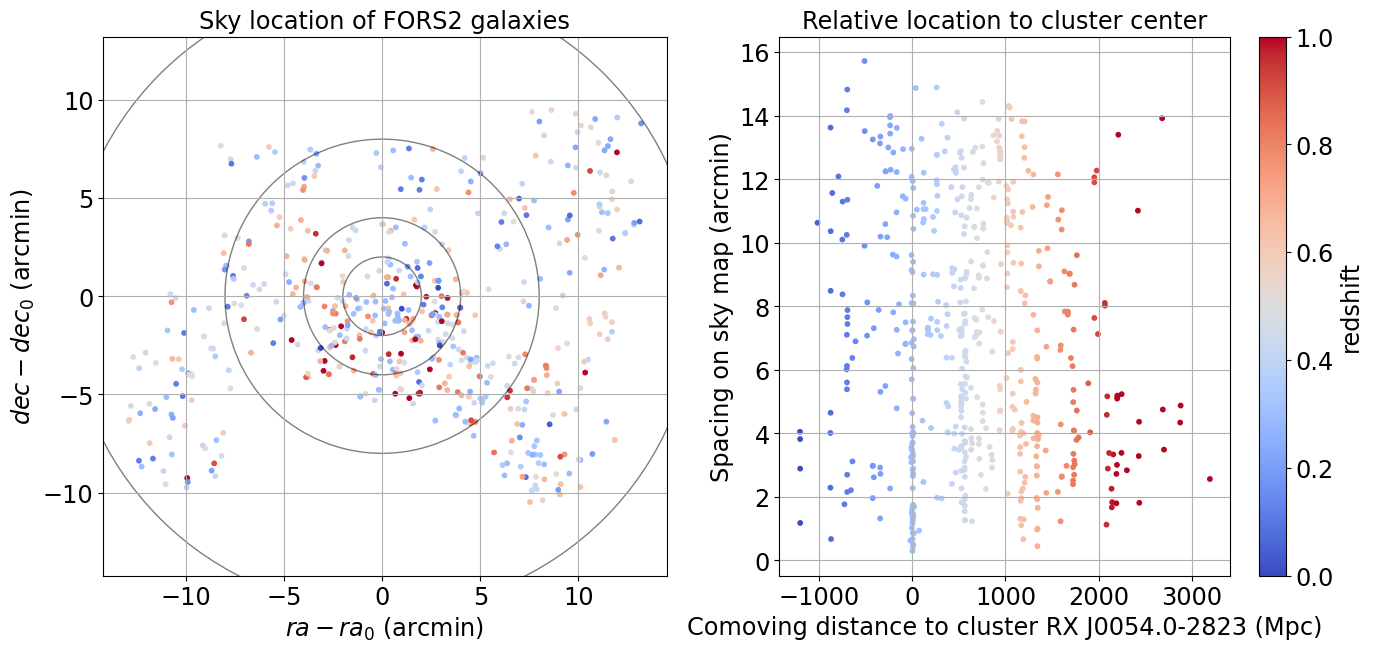

In [51]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
a1,a2 = axs.ravel()
a1.scatter((all_ra[_sel]-ra0*180/np.pi)*60, (all_dec[_sel]-dec0*180/np.pi)*60,c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
#im = ax.scatter(all_ra,all_dec,c=all_redshifts,s=10,marker="o",alpha=0.5,cmap="jet")
a1.axis('equal')
a1.grid()
c1=plt.Circle((0.,0.), 2., fill=False, alpha=0.5, label="Spacing: 2 arcmin")
c2=plt.Circle((0.,0.), 4., fill=False, alpha=0.5, label="Spacing: 4 arcmin")
c3=plt.Circle((0.,0.), 8., fill=False, alpha=0.5, label="Spacing: 6 arcmin")
c4=plt.Circle((0.,0.), 16., fill=False, alpha=0.5, label="Spacing: 8 arcmin")
a1.add_artist(c1)
a1.add_artist(c2)
a1.add_artist(c3)
a1.add_artist(c4)
a1.set_xlabel("$ra-ra_0$ (arcmin)")
a1.set_ylabel("$dec-dec_0$ (arcmin)")
a1.set_title("Sky location of FORS2 galaxies")
#a1.legend()

a2.scatter(all_dists,angles_to_center*60,c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
#im = ax.scatter(all_ra,all_dec,c=all_redshifts,s=10,marker="o",alpha=0.5,cmap="jet")
a2.grid()
a2.set_xlabel("Comoving distance to cluster RX J0054.0-2823 (Mpc)")
a2.set_ylabel("Spacing on sky map (arcmin)")
a2.set_title("Relative location to cluster center")

cbar = fig.colorbar(scalarMap2, ax=a2)
cbar.set_label('redshift')

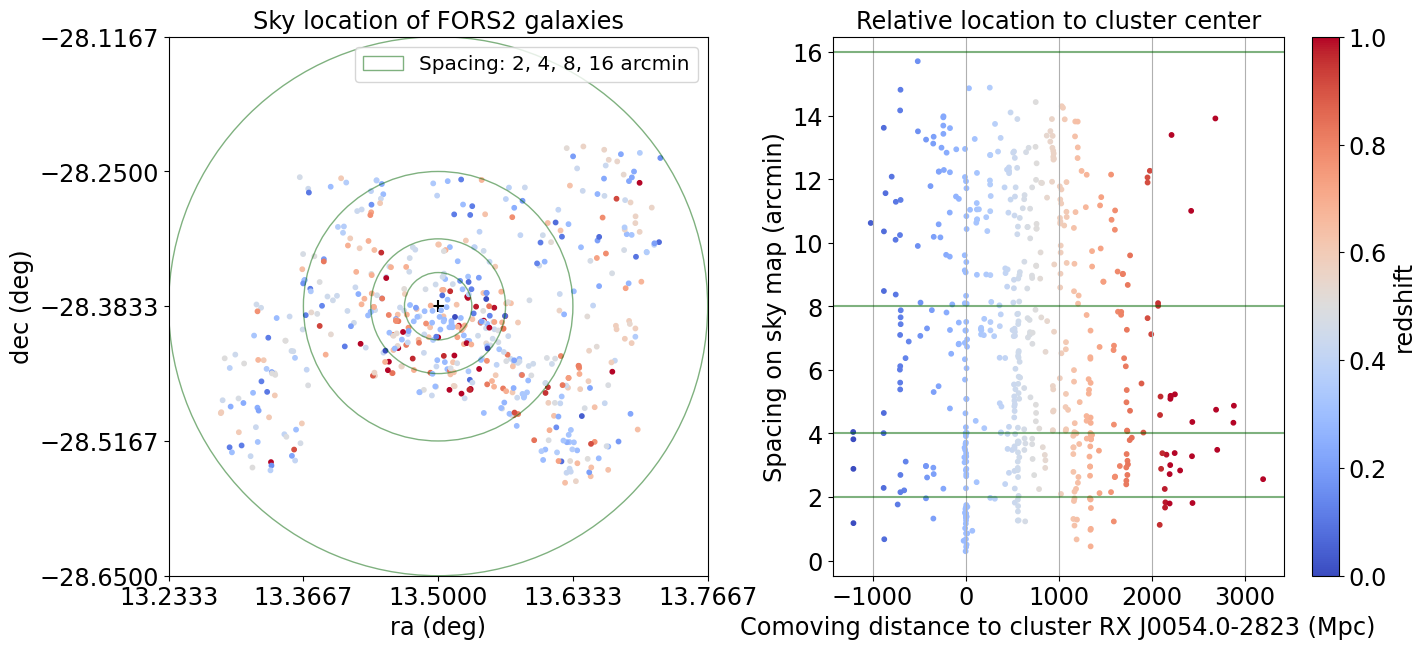

In [52]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
a1,a2 = axs.ravel()
a1.set_box_aspect(1.)
a1.scatter(ra0*180/np.pi,dec0*180/np.pi,c='k',marker='+', s=81, alpha=1)
a1.scatter(all_ra[_sel], all_dec[_sel],c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
#im = ax.scatter(all_ra,all_dec,c=all_redshifts,s=10,marker="o",alpha=0.5,cmap="jet")
#a1.grid()
c1=plt.Circle((ra0*180/np.pi,dec0*180/np.pi), 2./60, fill=False, alpha=0.5, color='darkgreen', label="Spacing: 2, 4, 8, 16 arcmin")
c2=plt.Circle((ra0*180/np.pi,dec0*180/np.pi), 4./60, fill=False, alpha=0.5, color='darkgreen')
c3=plt.Circle((ra0*180/np.pi,dec0*180/np.pi), 8./60, fill=False, alpha=0.5, color='darkgreen')
c4=plt.Circle((ra0*180/np.pi,dec0*180/np.pi), 16./60, fill=False, alpha=0.5, color='darkgreen')
a1.add_artist(c1)
a1.add_artist(c2)
a1.add_artist(c3)
a1.add_artist(c4)
a1.set_xticks(np.linspace(ra0*180/np.pi-16/60, ra0*180/np.pi+16/60, 5))
a1.set_yticks(np.linspace(dec0*180/np.pi-16/60, dec0*180/np.pi+16/60, 5))
a1.set_xlabel("ra (deg)")
a1.set_ylabel("dec (deg)")
a1.set_title("Sky location of FORS2 galaxies")
a1.legend()

a2.scatter(all_dists,angles_to_center*60,c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
#im = ax.scatter(all_ra,all_dec,c=all_redshifts,s=10,marker="o",alpha=0.5,cmap="jet")
a2.axhline(2., alpha=0.5, color='darkgreen')
a2.axhline(4., alpha=0.5, color='darkgreen')
a2.axhline(8., alpha=0.5, color='darkgreen')
a2.axhline(16., alpha=0.5, color='darkgreen')
a2.grid(True, axis='x')
a2.set_xlabel("Comoving distance to cluster RX J0054.0-2823 (Mpc)")
a2.set_ylabel("Spacing on sky map (arcmin)")
a2.set_title("Relative location to cluster center")

cbar = fig.colorbar(scalarMap2, ax=a2)
cbar.set_label('redshift')

/tmp/ipykernel_1651/1880353818.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(scalarMap2)


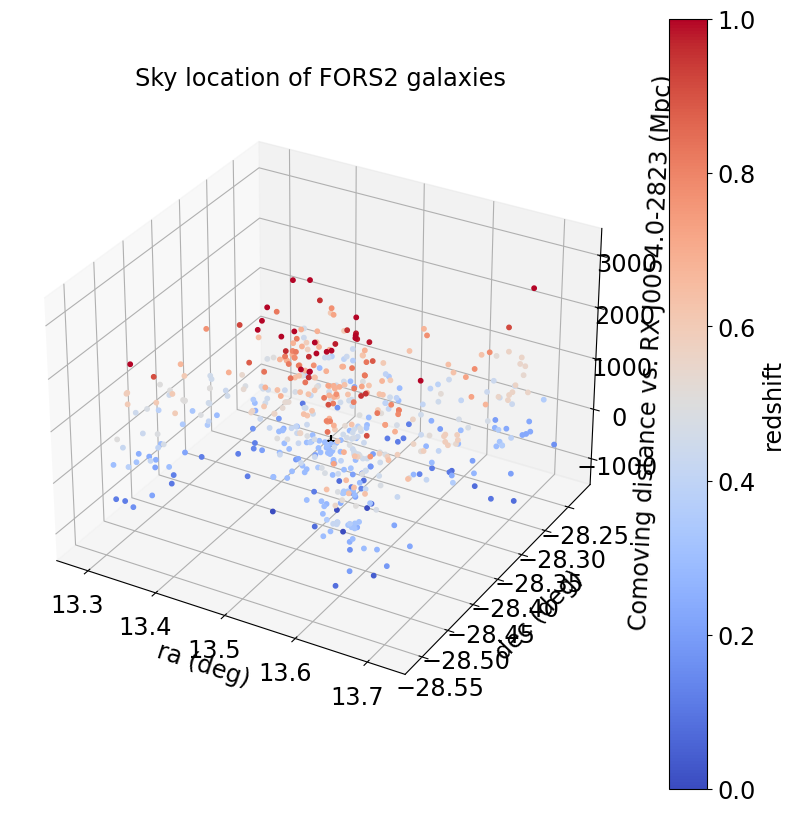

In [53]:
fig = plt.figure(figsize=(10,10))
a1 = fig.add_subplot(projection='3d')
#a1.set_box_aspect(1.)
a1.scatter(ra0*180/np.pi, dec0*180/np.pi, 0.0, c='k',marker='+', s=81, alpha=1)
a1.scatter(all_ra[_sel], all_dec[_sel], all_dists, c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
a1.set_xlabel("ra (deg)")
a1.set_ylabel("dec (deg)")
a1.set_zlabel("Comoving distance vs. RX J0054.0-2823 (Mpc)")
a1.set_title("Sky location of FORS2 galaxies")
a1.tick_params(length=1)
cbar = fig.colorbar(scalarMap2)
cbar.set_label('redshift')

Text(0.5, 1.0, 'Relative location to cluster center')

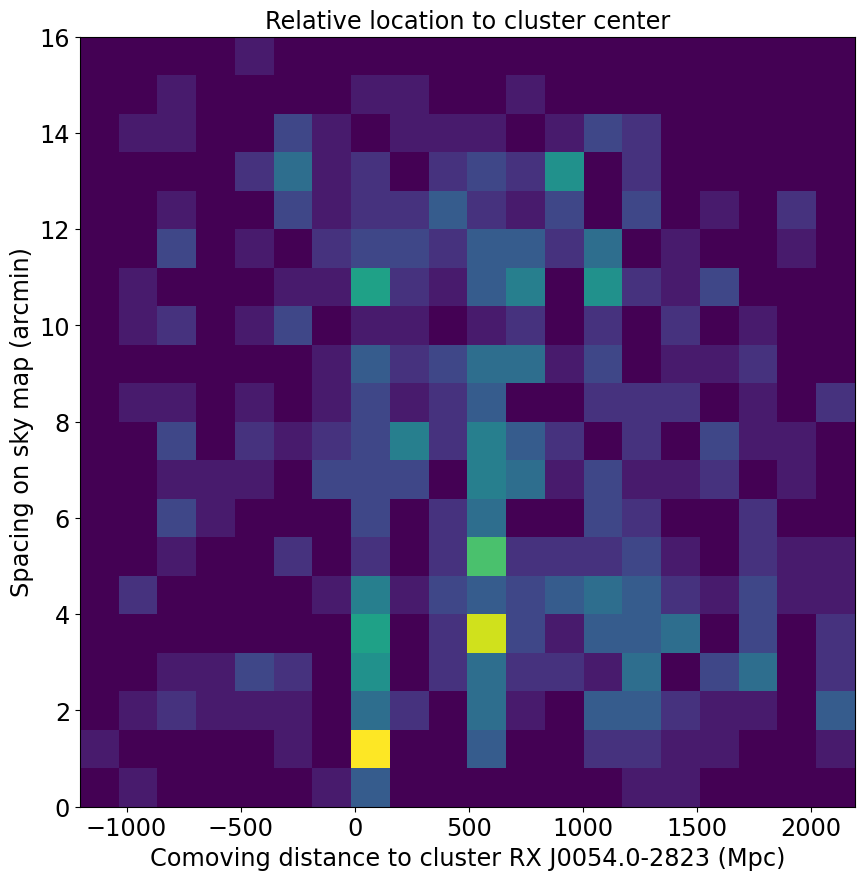

In [54]:
f,a = plt.subplots(1,1,figsize=(10,10))
a.hist2d(all_dists, angles_to_center*60,\
           range=[(comov_dist.comoving_dist(0.292, 0.)/comov_dist.mpc_m,\
                   comov_dist.comoving_dist(0.292, 1.)/comov_dist.mpc_m),\
                  (0., 16)],\
           bins=20)
a.set_xlabel("Comoving distance to cluster RX J0054.0-2823 (Mpc)")
a.set_ylabel("Spacing on sky map (arcmin)")
a.set_title("Relative location to cluster center")